In [17]:
!pip install box2d
!pip install gymnasium
!pip install gymnasium[box2d]
!pip install swig

In [18]:
!apt-get update
!apt-get install -y ffmpeg
!apt-get install xvfb
%pip install pyvirtualdisplay
%pip install gym
%pip install Pillow

Hit:1 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Get:4 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [119 kB]
Get:5 http://security.ubuntu.com/ubuntu jammy-security InRelease [110 kB]
Hit:6 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:7 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Fetched 229 kB in 2s (143 kB/s)
Reading package lists... Done
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
ffmpeg is already the newest version (7:4.4.2-0ubuntu0.22.04.1).
0 upgraded, 0 newly ins

In [19]:
import tensorflow as tf
import gym
import os
import random

from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense
from tensorflow.keras.regularizers import l2

import numpy as np
import scipy
import uuid
import shutil

import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import keras.backend as K

In [20]:
env = gym.make("LunarLander-v2")

print(f"Input: {env.observation_space}")
print(f"Output: {env.action_space}")

Input: Box([-1.5       -1.5       -5.        -5.        -3.1415927 -5.
 -0.        -0.       ], [1.5       1.5       5.        5.        3.1415927 5.        1.
 1.       ], (8,), float32)
Output: Discrete(4)


/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


In [21]:
def masked_huber_loss(mask_value, clip_delta):
  def f(y_true, y_pred):
    error = y_true - y_pred
    cond  = K.abs(error) < clip_delta
    mask_true = K.cast(K.not_equal(y_true, mask_value), K.floatx())
    masked_squared_error = 0.5 * K.square(mask_true * (y_true - y_pred))
    linear_loss  = mask_true * (clip_delta * K.abs(error) - 0.5 * (clip_delta ** 2))
    huber_loss = tf.where(cond, masked_squared_error, linear_loss)
    return K.sum(huber_loss) / K.sum(mask_true)
  f.__name__ = 'masked_huber_loss'
  return f

In [22]:
input_shape = (9,) # 8 variables in the environment + the fraction finished we add ourselves
outputs = 4

def create_model(learning_rate, regularization_factor):
  model = Sequential([
    Dense(64, input_shape=input_shape, activation="relu", kernel_regularizer=l2(regularization_factor)),
    Dense(64, activation="relu", kernel_regularizer=l2(regularization_factor)),
    Dense(64, activation="relu", kernel_regularizer=l2(regularization_factor)),
    Dense(outputs, activation='linear', kernel_regularizer=l2(regularization_factor))
  ])

  optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
  model.compile(optimizer=optimizer, loss=masked_huber_loss(0.0, 1.0))

  return model

In [23]:
def get_q_values(model, state):
  input = state[np.newaxis, ...]
  return model.predict(input)[0]

def get_multiple_q_values(model, states):
  return model.predict(states)

In [24]:
def select_action_epsilon_greedy(q_values, epsilon):
  random_value = random.uniform(0, 1)
  if random_value < epsilon:
    return random.randint(0, len(q_values) - 1)
  else:
    return np.argmax(q_values)

def select_best_action(q_values):
  return np.argmax(q_values)

In [25]:
class StateTransition():

  def __init__(self, old_state, action, reward, new_state, done):
    self.old_state = old_state
    self.action = action
    self.reward = reward
    self.new_state = new_state
    self.done = done

class ReplayBuffer():
  current_index = 0

  def __init__(self, size = 10000):
    self.size = size
    self.transitions = []

  def add(self, transition):
    if len(self.transitions) < self.size:
      self.transitions.append(transition)
    else:
      self.transitions[self.current_index] = transition
      self.__increment_current_index()

  def length(self):
    return len(self.transitions)

  def get_batch(self, batch_size):
    return random.sample(self.transitions, batch_size)

  def __increment_current_index(self):
    self.current_index += 1
    if self.current_index >= self.size - 1:
      self.current_index = 0

In [26]:
def calculate_target_values(model, target_model, state_transitions, discount_factor):
  states = []
  new_states = []
  for transition in state_transitions:
    states.append(transition.old_state)
    new_states.append(transition.new_state)

  new_states = np.array(new_states)

  q_values_new_state = get_multiple_q_values(model, new_states)
  q_values_new_state_target_model = get_multiple_q_values(target_model, new_states)

  targets = []
  for index, state_transition in enumerate(state_transitions):
    best_action = select_best_action(q_values_new_state[index])
    best_action_next_state_q_value = q_values_new_state_target_model[index][best_action]

    if state_transition.done:
      target_value = state_transition.reward
    else:
      target_value = state_transition.reward + discount_factor * best_action_next_state_q_value

    target_vector = [0] * outputs
    target_vector[state_transition.action] = target_value
    targets.append(target_vector)

  return np.array(targets)

In [27]:
def train_model(model, states, targets):
  model.fit(states, targets, epochs=1, batch_size=len(targets), verbose=0)

In [28]:
def copy_model(model):
  backup_file = 'backup_'+str(uuid.uuid4())
  model.save(backup_file)
  new_model = load_model(backup_file, custom_objects={ 'masked_huber_loss': masked_huber_loss(0.0, 1.0) })
  shutil.rmtree(backup_file)
  return new_model

In [29]:
class AverageRewardTracker():
  current_index = 0

  def __init__(self, num_rewards_for_average=100):
    self.num_rewards_for_average = num_rewards_for_average
    self.last_x_rewards = []

  def add(self, reward):
    if len(self.last_x_rewards) < self.num_rewards_for_average:
      self.last_x_rewards.append(reward)
    else:
      self.last_x_rewards[self.current_index] = reward
      self.__increment_current_index()

  def __increment_current_index(self):
    self.current_index += 1
    if self.current_index >= self.num_rewards_for_average:
      self.current_index = 0

  def get_average(self):
    return np.average(self.last_x_rewards)


class FileLogger():

  def __init__(self, file_name='progress.log'):
    self.file_name = file_name
    self.clean_progress_file()

  def log(self, episode, steps, reward, average_reward):
    f = open(self.file_name, 'a+')
    f.write(f"{episode};{steps};{reward};{average_reward}\n")
    f.close()

  def clean_progress_file(self):
    if os.path.exists(self.file_name):
      os.remove(self.file_name)
    f = open(self.file_name, 'a+')
    f.write("episode;steps;reward;average\n")
    f.close()

In [30]:
replay_buffer_size = 200000
learning_rate = 0.001
regularization_factor = 0.001
training_batch_size = 128
training_start = 256
max_episodes = 100
max_steps = 500
target_network_replace_frequency_steps = 1000
model_backup_frequency_episodes = 100
starting_epsilon = 1.0
minimum_epsilon = 0.01
epsilon_decay_factor_per_episode = 0.995
discount_factor = 0.99
train_every_x_steps = 4

In [ ]:
replay_buffer = ReplayBuffer(replay_buffer_size)
model = create_model(learning_rate, regularization_factor)
target_model = copy_model(model)
epsilon = starting_epsilon
step_count = 0
average_reward_tracker = AverageRewardTracker(100)
file_logger = FileLogger()

for episode in range(max_episodes):
  print(f"Starting episode {episode} with epsilon {epsilon}")

  episode_reward = 0
  state = env.reset()
  fraction_finished = 0.0
  state = np.append(state, fraction_finished)

  first_q_values = get_q_values(model, state)
  print(f"Q values: {first_q_values}")
  print(f"Max Q: {max(first_q_values)}")

  for step in range(1, max_steps + 1):
    step_count += 1
    q_values = get_q_values(model, state)
    action = select_action_epsilon_greedy(q_values, epsilon)
    new_state, reward, done, info = env.step(action)

    fraction_finished = (step + 1) / max_steps
    new_state = np.append(new_state, fraction_finished)

    episode_reward += reward

    if step == max_steps:
      print(f"Episode reached the maximum number of steps. {max_steps}")
      done = True

    state_transition = StateTransition(state, action, reward, new_state, done)
    replay_buffer.add(state_transition)

    state = new_state

    if step_count % target_network_replace_frequency_steps == 0:
      print("Updating target model")
      target_model = copy_model(model)

    if replay_buffer.length() >= training_start and step_count % train_every_x_steps == 0:
      batch = replay_buffer.get_batch(batch_size=training_batch_size)
      targets = calculate_target_values(model, target_model, batch, discount_factor)
      states = np.array([state_transition.old_state for state_transition in batch])
      train_model(model, states, targets)

    if done:
      break

  average_reward_tracker.add(episode_reward)
  average = average_reward_tracker.get_average()

  print(
    f"episode {episode} finished in {step} steps with reward {episode_reward}. "
    f"Average reward over last 100: {average}")

  if episode != 0 and episode % model_backup_frequency_episodes == 0:
    backup_file = f"model_{episode}.h5"
    print(f"Backing up model to {backup_file}")
    model.save(backup_file)

  epsilon *= epsilon_decay_factor_per_episode
  epsilon = max(minimum_epsilon, epsilon)

Starting episode 0 with epsilon 1.0
1/1 [==============================] - 0s 93ms/step
Q values: [ 0.03190084 -0.09703448  0.00373538 -0.05660808]
Max Q: 0.031900838017463684
1/1 [==============================] - 0s 24ms/step


/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 40ms/step
episode 55 finished in 78 steps with reward -60.51543563268716. Average reward over last 100: -149.8447372535529
Starting episode 56 with epsilon 0.7552531090661897
1/1 [==============================] - 0s 46ms/step
Q values: [2.808991   4.5608315  4.641011   0.94750303]
Max Q: 4.6410112380981445
1/1 [==============================] - 0s 28ms/step
episode 56 finished in 81 steps with reward -50.33904045106919. Average reward over last 100: -148.09902327456194
Starting episode 57 with epsilon 0.7514768435208588
1/1 [==============================] - 0s 30ms/step
Q values: [3.4546933 1.7613428 0.5099349 4.932657 ]
Max Q: 4.932656764984131
1/1 [==============================] - 0s 30ms/step
Updating target model
1/1 [==============================] - 0s 23ms/step
episode 57 finished in 112 steps with reward -115.45784549805589. Average reward over last 100: -147.5362443473808
Starting e

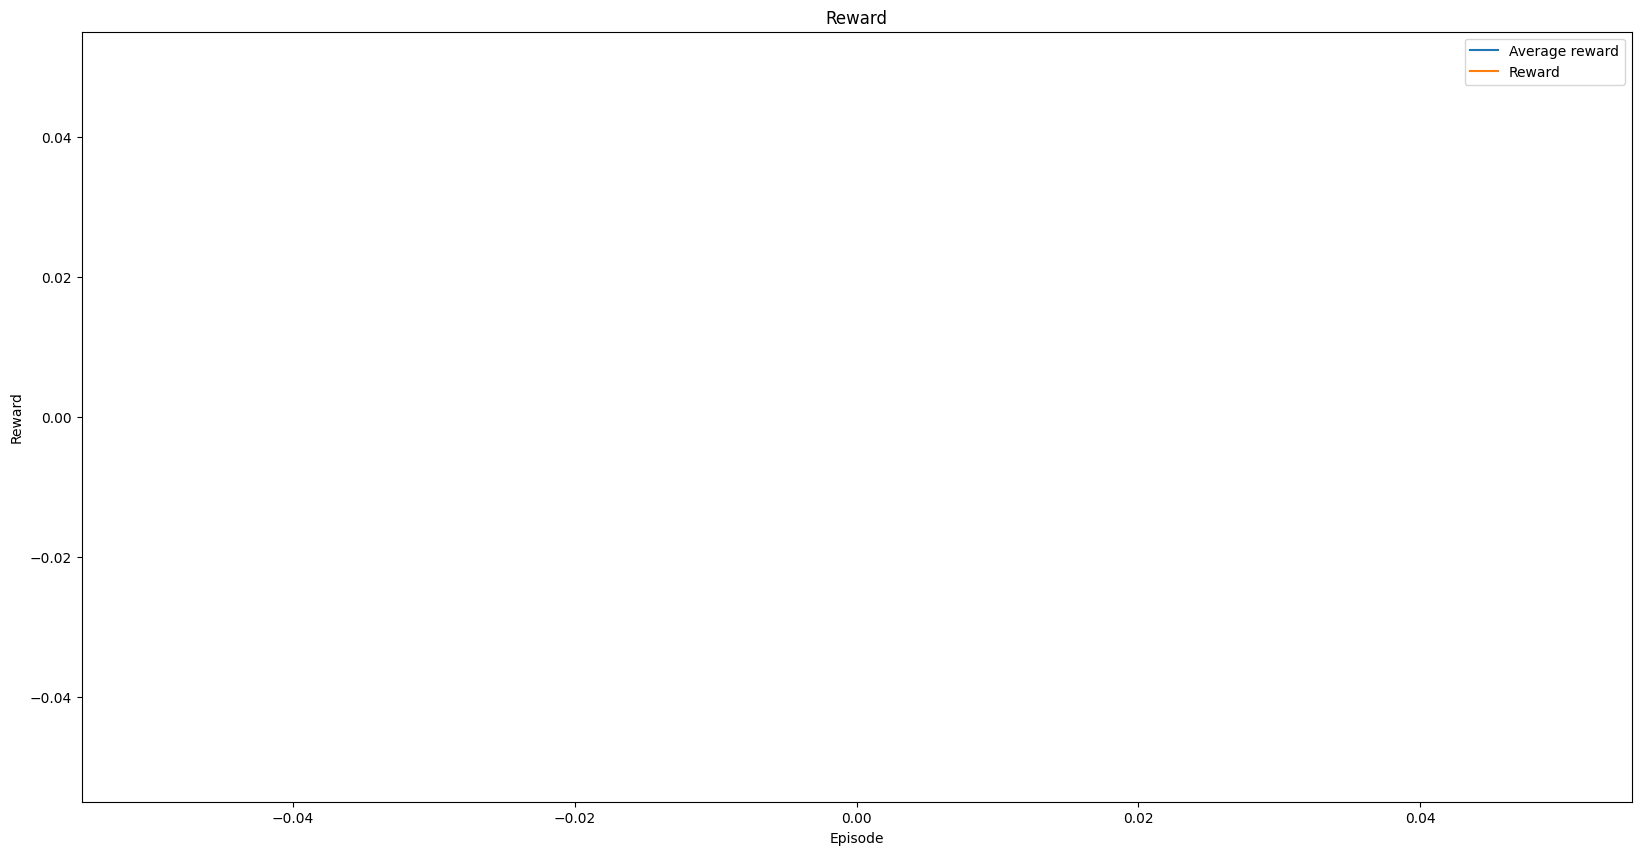

In [33]:
data = pd.read_csv(file_logger.file_name, sep=';')

plt.figure(figsize=(20,10))
plt.plot(data['average'])
plt.plot(data['reward'])
plt.title('Reward')
plt.ylabel('Reward')
plt.xlabel('Episode')
plt.legend(['Average reward', 'Reward'], loc='upper right')
plt.show()